In [1]:
import io
from IPython.nbformat import current
def execute_notebook(nbfile):
    with io.open(nbfile) as f:
        nb = current.read(f, 'json')
    ip = get_ipython()
    for cell in nb.worksheets[0].cells:
        if cell.cell_type != 'code':
            continue
        ip.run_cell(cell.input)
execute_notebook("../../imports/imports.ipynb")

Populating the interactive namespace from numpy and matplotlib


/cellar/users/ramarty/anaconda/lib/python2.7/site-packages/IPython/nbformat/current.py:19: UserWarning: IPython.nbformat.current is deprecated.

- use IPython.nbformat for read/write/validate public API
- use IPython.nbformat.vX directly to composing notebooks of a particular version

  """)


##Panel C <br>
Data requirements: affinities of random residues, affinities of Abelin et al data


In [2]:
alleles = ['A0101', 'A0201', 'A0203', 'A0204', 'A0207', 'A0301', 'A2402', 'A2902', 'A3101', 'A6802', 'B3501', 
           'B4402', 'B4403', 'B5101', 'B5401', 'B5701']
proper_alleles = ['HLA-{0}:{1}'.format(x[:3], x[3:]) for x in alleles]

In [3]:
observed = []
for allele in alleles:
    tmp_df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/MS_validation/single_allele/{0}.best_rank.csv'.format(allele), index_col=0)
    tmp_df.columns = ['score']
    observed.extend(tmp_df.score)
observed = pd.Series(observed)

In [4]:
random_df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/random_allele_matrix.csv', index_col=0)
random = []
for allele in proper_alleles:
    random.extend(random_df[allele])
random = pd.Series(random)

In [5]:
TP, FP = [], []
for cutoff in [0, 0.1, 0.25, 0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]:
    TP.append((observed < cutoff).mean())
    FP.append((random < cutoff).mean())

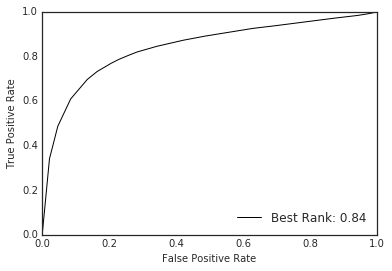

In [14]:
plt.plot(FP, TP, c='k', label='{0}: {1}'.format('Best Rank', str(round(metrics.auc(FP, TP), 2))))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.savefig('/cellar/users/ramarty/Data/hla/git_data/figures/ROC.BR.pdf')

##Panel D <br>
Data requirements: affinities of cell line mutations, presence or absence in MS data

In [7]:
expression = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/cell_line_gene_expression.csv', index_col=0)
expression['gene'] = expression.index

In [8]:
def get_gene(x):
    return x.split('_')[0]

In [9]:
expression.head()

,A2780,ov90,HeLa,skov3,A375,gene
Gene name,,,,,,
TSPAN6,7.756051,8.331341,7.761063,7.284218,6.332266,TSPAN6
TNMD,2.816289,2.800790,2.701612,2.877566,2.739713,TNMD
DPM1,9.880065,9.728564,9.727289,9.473404,10.688490,DPM1
SCYL3,4.466949,3.895457,4.120543,3.787772,4.733920,SCYL3
C1orf112,4.010732,3.707918,3.617792,3.014743,3.567905,C1orf112


In [10]:
cell_lines = ['A2780', 'ov90', 'HeLa', 'skov3', 'A375']
observed_totals, predicted_totals = [], []
for i, cell in enumerate(cell_lines):
    # cell line affinities; filtering (common, ensembl) already complete
    df = pd.read_csv('/cellar/users/ramarty/Data/hla/git_data/data/MS_validation/mutations/{0}.csv'.format(cell), index_col=0)
    df['gene'] = df['mutation'].apply(get_gene)
    
    # reduce to expressed
    df = pd.merge(df, expression, on='gene', how='inner')
    df = df[df[cell] > df[cell].quantile(0.25)]
    
    # strong
    strong = (df.BR < 0.5)
    predicted_totals.append(len(df[strong]))
    observed_totals.append(len(df[(strong)&(df.observed)]))
    
    # weak
    weak = ((df.BR >= 0.5) & (df.BR < 2))
    predicted_totals.append(len(df[weak]))
    observed_totals.append(len(df[(weak)&(df.observed)]))

In [11]:
results_df = pd.DataFrame({'Cell_line': ['A2780', 'A2780', 'OV90', 'OV90', 'HeLa', 'HeLa','SKOV3', 'SKOV3', 'A375', 'A375'],
                           'Binding Strength': ['Strong', 'Weak']*5,
                           'Observed': observed_totals,
                           'Predicted': predicted_totals})
results_df['Fraction_observed'] = results_df.Observed / results_df.Predicted

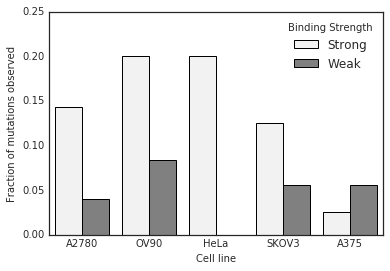

In [15]:
sns.barplot(x='Cell_line', y='Fraction_observed', hue='Binding Strength', data=results_df, color='grey')
plt.xlabel('Cell line')
plt.ylabel('Fraction of mutations observed')
plt.savefig('/cellar/users/ramarty/Data/hla/git_data/figures/MS_validation.mutations.pdf')